# Generative Adversarial Network
##### Train a  Deep Convolutional GAN (DCGAN) to learn how to write handwritten digits

## Set up

In [1]:
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from scipy.io import loadmat
import keras.backend as K
from pylab import rcParams
import numpy as np
import keras
import cv2

%matplotlib inline

Using TensorFlow backend.


## Function for later use

Plots given data.

In [2]:
def plot_data(dataset):
    plt.figure(figsize=(5, 4))
    for i in range(20):
        plt.subplot(4, 5, i+1)
        plt.imshow(dataset[i], cmap='gray')
        plt.xticks([])
        plt.yticks([])
    
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

Save a wall of generated MNIST images

In [3]:
def save_images(generated_images, num):
    str_num = str(num)
    n_images = len(generated_images)
    rows = 4
    cols = n_images//rows
    
    plt.figure(figsize=(cols, rows))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    fig_num = 'Outputs/' + str_num + '.png'
    plt.savefig(fig_num)

Show the losses.

In [4]:
def show_results(losses):
    labels = ['Classifier', 'Discriminator', 'Generator']
    losses = np.array(losses)    
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()

Generate latent samples.

In [5]:
def make_latent_samples(n_samples, sample_size):
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

## Loading MNIST Dataset
Dataset of 70,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.


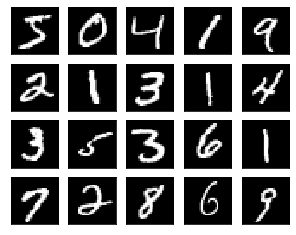

In [6]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
plot_data(X_train)

## Preprocess
The generator is using tanh activation, for which we need to preprocess the image data into the range between -1 and 1.

In [7]:
def preprocess(x):    
    x = x.reshape(-1, 28, 28, 1) # 28,28,1
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

In [8]:
def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

Apply the preprocessing on the train and test images

In [9]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

## Define the Generator Model 
#### The generator model is responsible for creating new, fake but plausible images of handwritten digits.
    ● Input: latent sample of 100 random numbers.  
    ● Output: generates a 28x28 image with 1 channel.

1) The first section accepts 784 data points(28X28), than the activations from these nodes can be reshaped into something image-like(7x7 with 16 filters)  

2) The Second section will up-sample the data shape into 14x14.
The Conv2DTranspose layer can be configured with a stride of (2×2) that will quadruple the area of the input feature maps (double their width and height dimensions, from 7X7 to 14X14)

3) The third section will up-sample the data shape into 28x28.

In [10]:
def define_generator(input_size, leaky_alpha):

    gen = Sequential()
    
    # first section
    gen.add(Dense(784, input_shape=(input_size,)))
    gen.add(Reshape((7, 7, 16)))
    gen.add(BatchNormalization())
    gen.add(LeakyReLU(alpha=leaky_alpha))
    
    # second section, upsample to 14x14X32
    gen.add(Conv2DTranspose(32, kernel_size=5, strides=2, padding='same'))
    gen.add(BatchNormalization())
    gen.add(LeakyReLU(alpha=0.2))
    
    # third section, upsample to 28x28X1
    gen.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding='same'))
    gen.add(Activation('tanh'))
    
    # summary and plot
    plot_model(gen, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)
       
    return gen
    

In [11]:
g = define_generator(100, 0.2)
g.summary()







_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               79184     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 16)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 16)          64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 32)        12832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 32)        0         
____

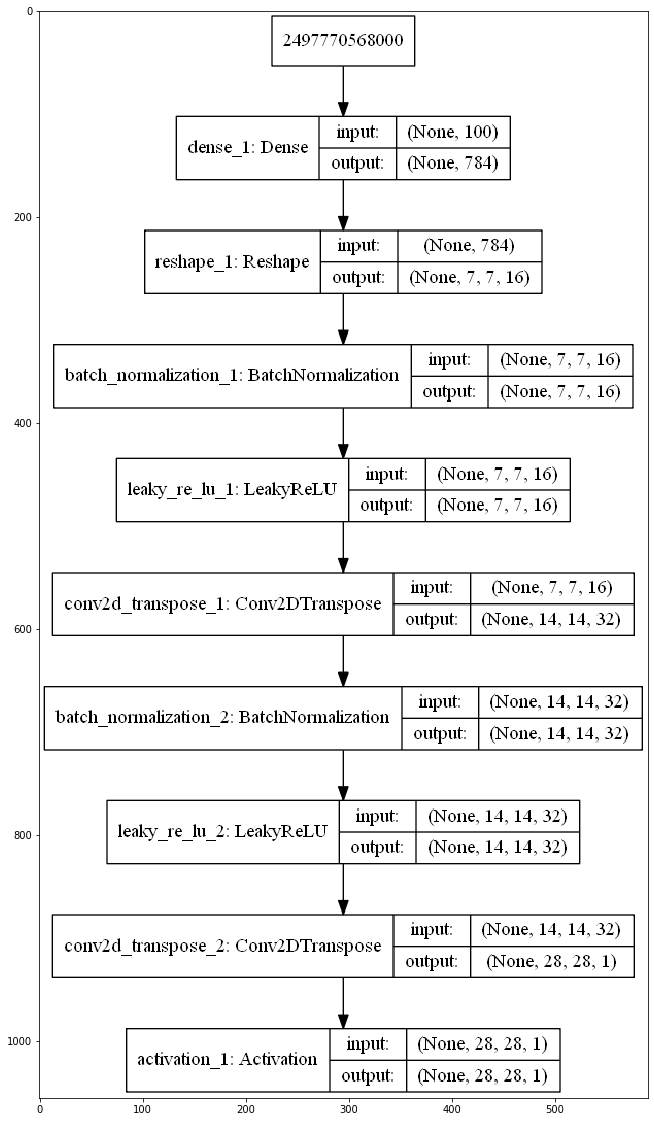

In [12]:
rcParams['figure.figsize'] = 25, 20
generator_summary = cv2.imread('generator_plot.png')
plt.imshow(generator_summary[:,:,::-1])

As the model is not trained, the generated images are completely random pixel values in [0, 1]

(28, 28, 1)


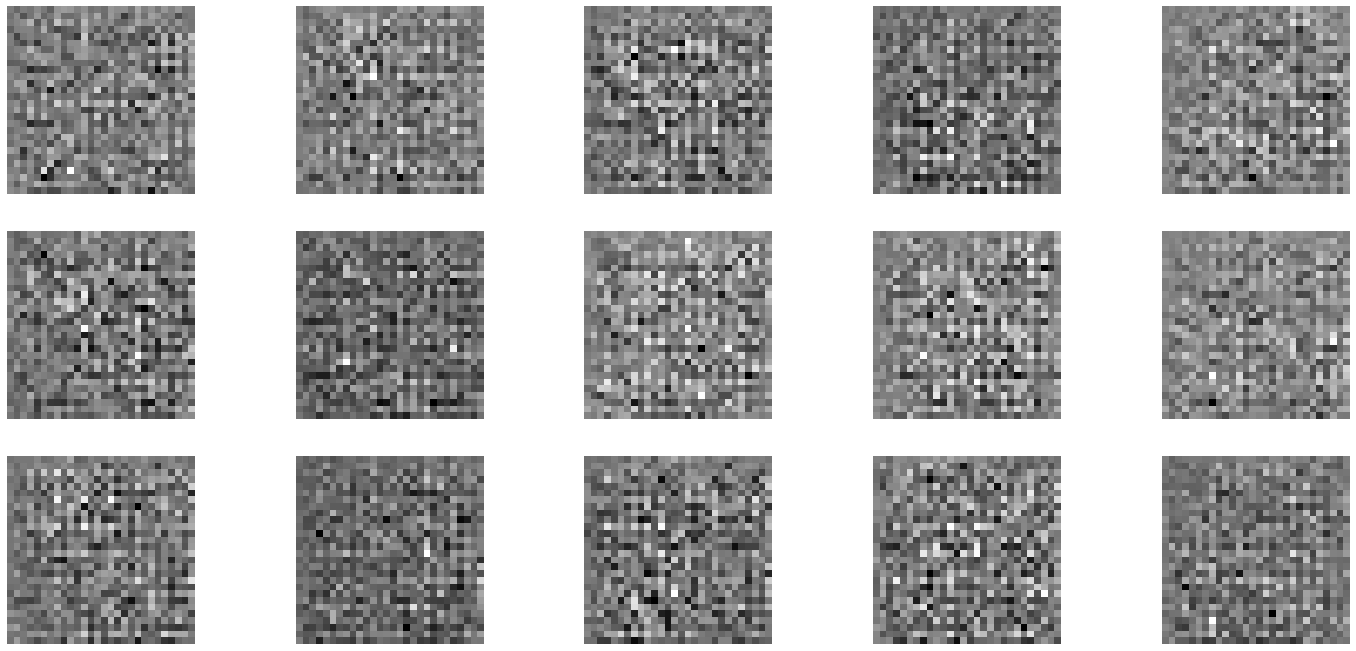

In [13]:
non_trained_samples = make_latent_samples(128, 100)
non_trained_output = g.predict_on_batch(non_trained_samples)

print(non_trained_output[0].shape)
for i in range(15):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(non_trained_output[i, :, :, 0], cmap='gray')
plt.show()

## Define the discriminator model
The model take a sample image from dataset as input and output a classification prediction as to whether the sample is real or fake.
    
● First section(input): It is a convolutional neural network that takes a 28x28 image with 1 channel. We will use Conv2D with 32 filters and stride of 2, that will change the size to 14x14 image with 1 channel.

● Second section: will use Conv2D with 32 filters and stride of 2, that will change the size to 7x7 image with 1 channel.

● Third section: is fully connected layer.

● Outputs: binary classification, the activation of the output layer is sigmoid and the discriminator outputs a probability of the image being real.

In [14]:
def define_discriminator(leaky_alpha):
    
    dis = Sequential()
    
    # first section
    dis.add(Conv2D(32, kernel_size=5, strides=2, padding='same', input_shape=(28,28,1)))
    dis.add(LeakyReLU(alpha=leaky_alpha))
    
    # second section
    dis.add(Conv2D(16, kernel_size=5, strides=2, padding='same'))
    dis.add(BatchNormalization())
    dis.add(LeakyReLU(alpha=leaky_alpha))
    
    # third section, FC
    dis.add(Flatten())
    dis.add(Dense(784))
    dis.add(BatchNormalization())
    dis.add(LeakyReLU(alpha=leaky_alpha))
    
    # output layer
    dis.add(Dense(1))
    dis.add(Activation('sigmoid'))        
    
    # summary and plot
    rcParams['figure.figsize'] = 25, 25
    plot_model(dis, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)
    
    return dis
    

In [15]:
d = define_discriminator(0.2)
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          12816     
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 16)          64        
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               615440    
__________

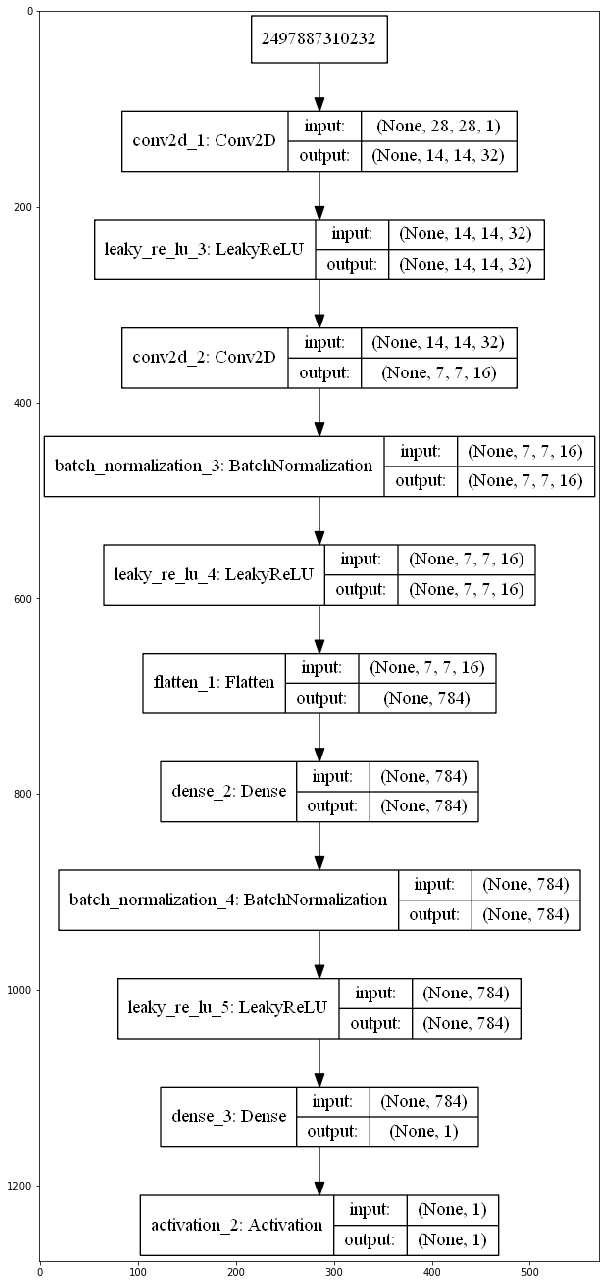

In [16]:
rcParams['figure.figsize'] = 20, 23
discriminator_summary = cv2.imread('discriminator_plot.png')
plt.imshow(discriminator_summary[:,:,::-1])

## Define Deep Convolutional Generative Adversarial Network(DGAN)
A new DGAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space and generates samples that are fed into the discriminator model directly, classified, and the output of this DGAN model can be used to update the model weights of the generator.

In [17]:
def define_DCGAN(sample_size, g_learning_rate, g_beta_1, d_learning_rate,d_beta_1, leaky_alpha):
    K.clear_session()
    
    # create generator
    generator = define_generator(sample_size, leaky_alpha)
    
    # create discriminator
    discriminator = define_discriminator(leaky_alpha)
    discriminator.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta_1), loss='binary_crossentropy')
    
    # combines the generator and discriminator models
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss='binary_crossentropy')
    
    # summary and plot
    rcParams['figure.figsize'] = 5, 5
    gan.summary()
    plot_model(gan, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)
    
    return gan, generator, discriminator

In [18]:
define_DCGAN(100, 0, 0, 0, 0, 0)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         93009     
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 633073    
Total params: 726,082
Trainable params: 724,386
Non-trainable params: 1,696
_________________________________________________________________


(<keras.engine.sequential.Sequential at 0x24593b43ef0>,
 <keras.engine.sequential.Sequential at 0x24592c62780>)

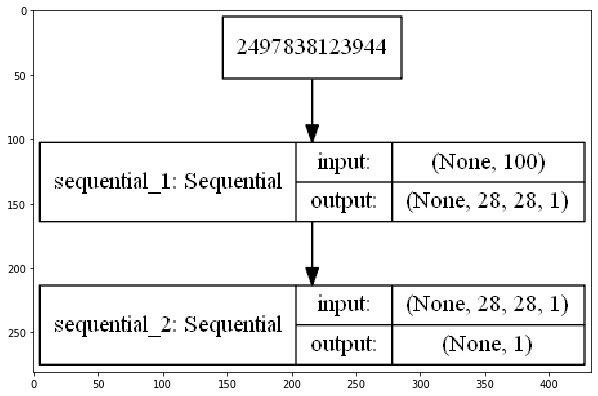

In [19]:
rcParams['figure.figsize'] = 10, 10

gan_summary = cv2.imread('gan_plot.png')
plt.imshow(gan_summary[:,:,::-1])

## Functions for training

Set the discriminator to trainable or non-trainable, that will be explained in Training section

In [20]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable 

Create a batch of labels.

In [21]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

## Training 

When training the generator via the GAN, the expect labels are all 1s. Initially, the generator produces not very realistic images so the discriminator classifies them as 0s, which causes the back-propagation to adjust the weights inside the generator. The discriminator is not affected as we set it non-trainable in this step.

        
    Get labels for the batch size and the test size, and than  
    create a GAN, a generator and a discriminator.     
    Training Loop:        
        1) Prepare a batch of real images and batch of fake images generated by the generator.
        2) Make the discriminator trainable and than train the discriminator to classify the real and fake images.
        3) Make the discriminator non-trainable(explained above), and than train the generator via the GAN.

In [22]:
def train(g_learning_rate,g_beta_1,d_learning_rate,d_beta_1,leaky_alpha,smooth=0.1,sample_size=100,epochs=100,batch_size=128,eval_size=16,show_details=True):
        
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)
    
    
    gan, generator, discriminator = define_DCGAN(sample_size, g_learning_rate, g_beta_1,d_learning_rate,d_beta_1, leaky_alpha)
    
    losses = []
    fig = 0
    for e in range(epochs):
        for i in range(len(X_train_real)//batch_size):
            
            '''1 line'''
            # real sample
            X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
            
            # fake sample
            latent_samples = make_latent_samples(batch_size, sample_size)
            X_batch_fake = generator.predict_on_batch(latent_samples)
            
            '''2 line'''           
            make_trainable(discriminator, True)
            # train on real images with 1 lable
            discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
            # train on fake images with 0 lable
            discriminator.train_on_batch(X_batch_fake, y_train_fake)
            
            '''3 line''' 
            make_trainable(discriminator, False)
            # train generator via the GAN, with 1 lable!
            gan.train_on_batch(latent_samples, y_train_real)
            
        # evaluate
        X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]

        latent_samples = make_latent_samples(eval_size, sample_size)
        X_eval_fake = generator.predict_on_batch(latent_samples)

        d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
        d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
        g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!

        losses.append((d_loss, g_loss))

        print("Epoch:{:>3}/{} Discriminator Loss:{:>7.4f} Generator Loss:{:>7.4f}".format(
            e+1, epochs, d_loss, g_loss))
        
        save_images(X_eval_fake, fig)
        fig = fig + 1        
        
    if show_details:
        show_results(losses)
    return generator

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         93009     
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 633073    
Total params: 726,082
Trainable params: 724,386
Non-trainable params: 1,696
_________________________________________________________________


C:\Users\henna\conda\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\henna\conda\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:  1/100 Discriminator Loss: 1.0576 Generator Loss: 1.5133
Epoch:  2/100 Discriminator Loss: 4.5200 Generator Loss: 0.0756
Epoch:  3/100 Discriminator Loss:11.6135 Generator Loss:11.9459
Epoch:  4/100 Discriminator Loss: 3.9750 Generator Loss: 5.7119
Epoch:  5/100 Discriminator Loss: 4.6859 Generator Loss: 4.7223
Epoch:  6/100 Discriminator Loss: 7.1634 Generator Loss: 7.0448
Epoch:  7/100 Discriminator Loss:13.1618 Generator Loss:12.5705
Epoch:  8/100 Discriminator Loss: 8.8384 Generator Loss: 9.2786
Epoch:  9/100 Discriminator Loss: 7.4795 Generator Loss: 8.2770
Epoch: 10/100 Discriminator Loss: 5.4598 Generator Loss: 6.5752
Epoch: 11/100 Discriminator Loss: 2.4460 Generator Loss: 2.7859
Epoch: 12/100 Discriminator Loss:15.0653 Generator Loss:14.8886
Epoch: 13/100 Discriminator Loss:12.7110 Generator Loss:14.6400
Epoch: 14/100 Discriminator Loss: 5.5877 Generator Loss: 6.5309
Epoch: 15/100 Discriminator Loss: 3.7724 Generator Loss: 5.1754
Epoch: 16/100 Discriminator Loss: 7.0376

C:\Users\henna\conda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


Epoch: 22/100 Discriminator Loss: 1.9998 Generator Loss: 1.4517
Epoch: 23/100 Discriminator Loss: 7.2931 Generator Loss: 4.9148
Epoch: 24/100 Discriminator Loss: 3.4518 Generator Loss: 3.9878
Epoch: 25/100 Discriminator Loss: 9.0426 Generator Loss:10.2029
Epoch: 26/100 Discriminator Loss: 3.5414 Generator Loss: 4.5433
Epoch: 27/100 Discriminator Loss: 5.5252 Generator Loss: 5.8127
Epoch: 28/100 Discriminator Loss:10.6397 Generator Loss: 9.2372
Epoch: 29/100 Discriminator Loss: 2.6971 Generator Loss: 3.6572
Epoch: 30/100 Discriminator Loss: 3.9542 Generator Loss: 4.2964
Epoch: 31/100 Discriminator Loss: 8.7772 Generator Loss: 7.6204
Epoch: 32/100 Discriminator Loss: 5.4707 Generator Loss: 6.1697
Epoch: 33/100 Discriminator Loss: 1.8080 Generator Loss: 2.3879
Epoch: 34/100 Discriminator Loss: 3.7401 Generator Loss: 3.9629
Epoch: 35/100 Discriminator Loss: 3.2883 Generator Loss: 4.7044
Epoch: 36/100 Discriminator Loss: 3.4564 Generator Loss: 0.5829
Epoch: 37/100 Discriminator Loss: 5.5352

C:\Users\henna\conda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


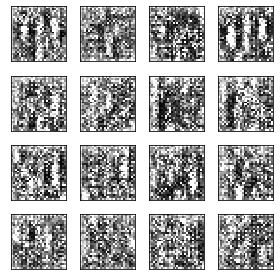

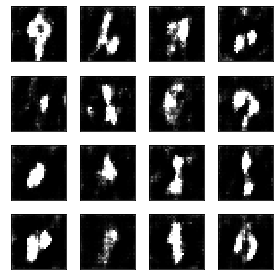

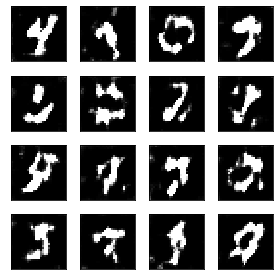

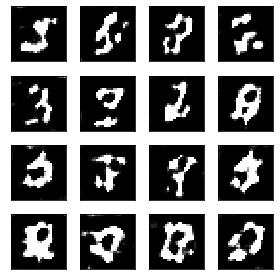

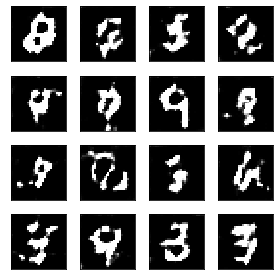

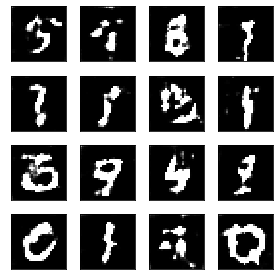

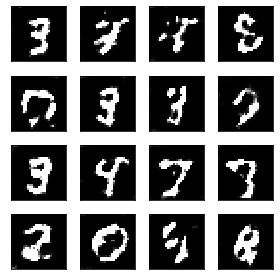

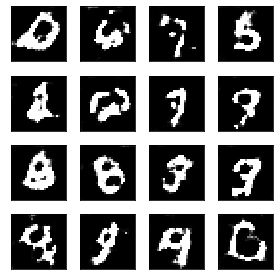

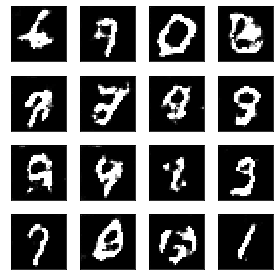

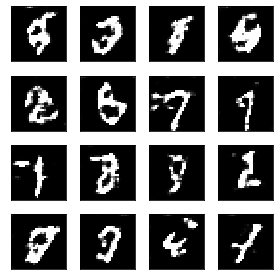

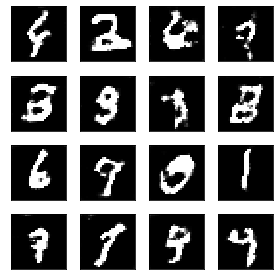

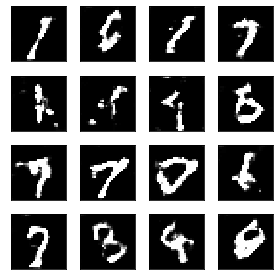

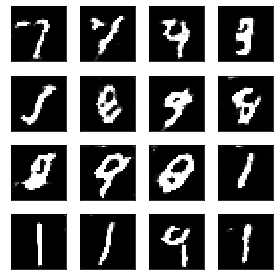

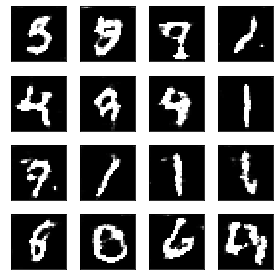

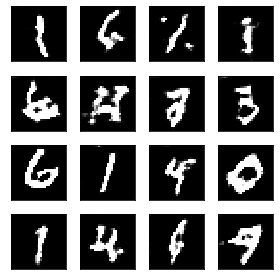

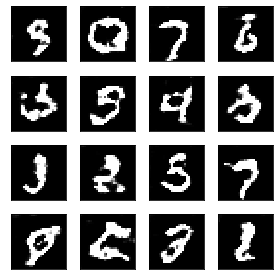

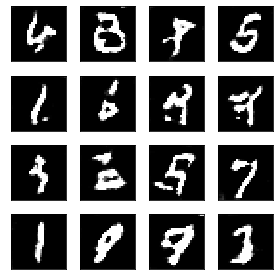

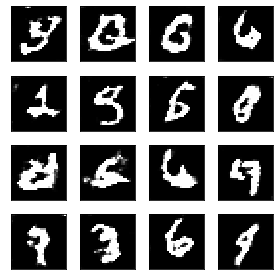

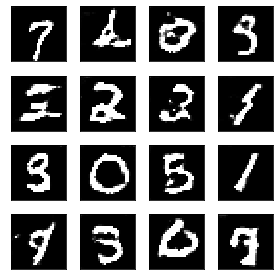

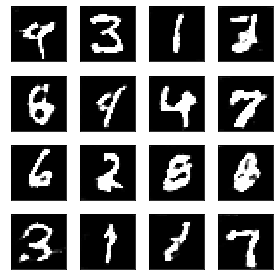

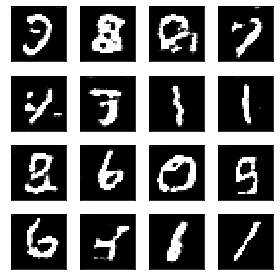

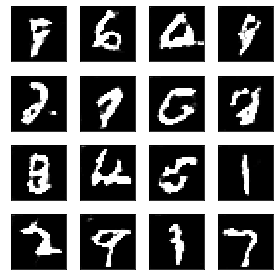

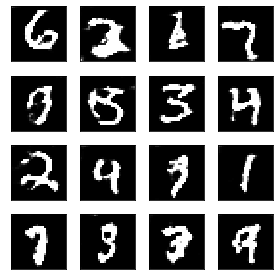

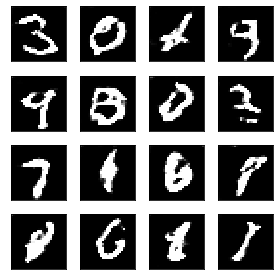

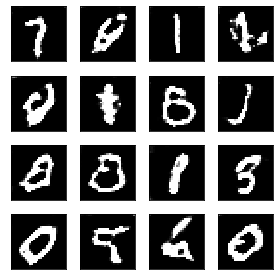

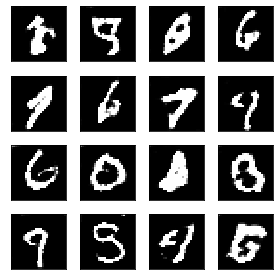

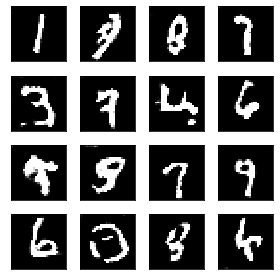

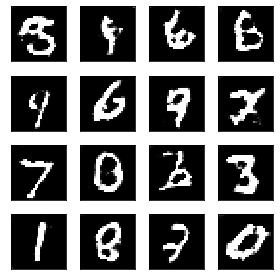

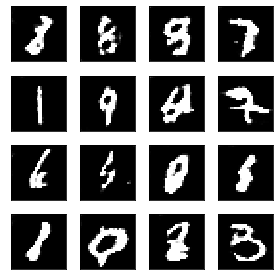

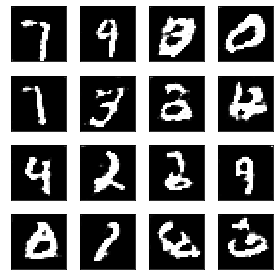

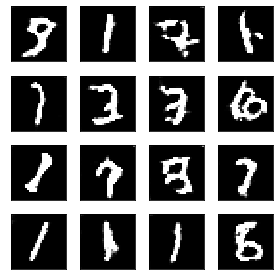

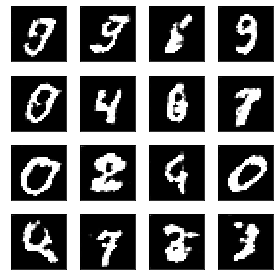

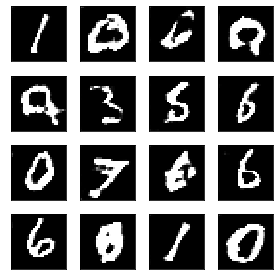

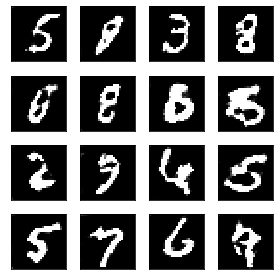

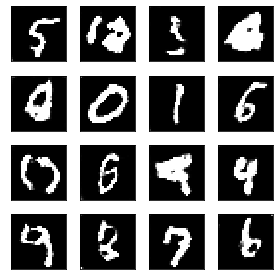

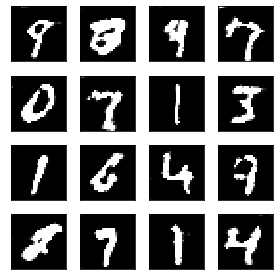

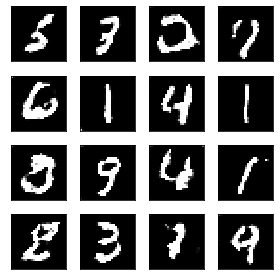

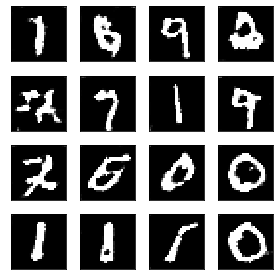

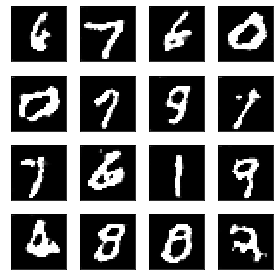

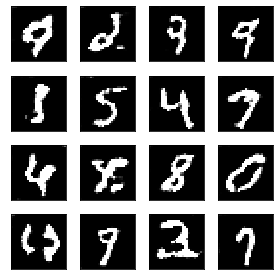

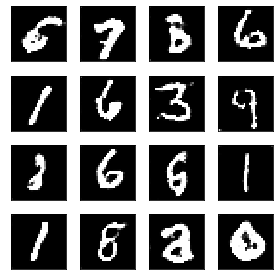

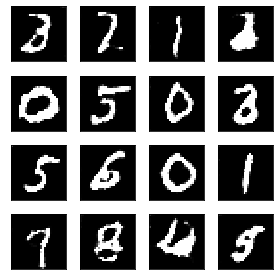

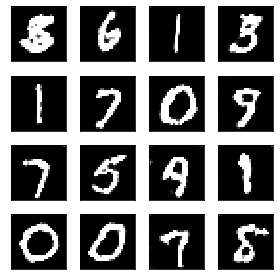

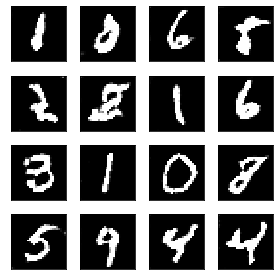

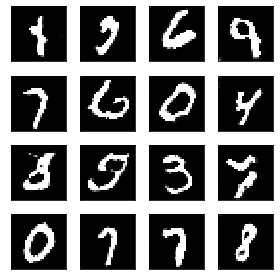

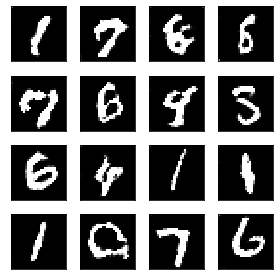

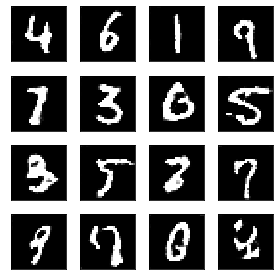

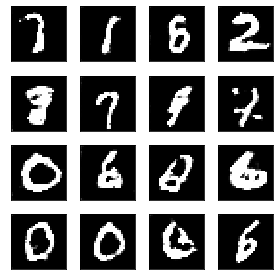

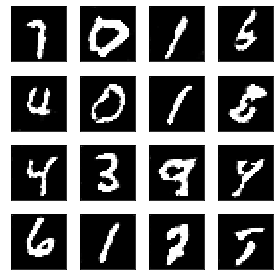

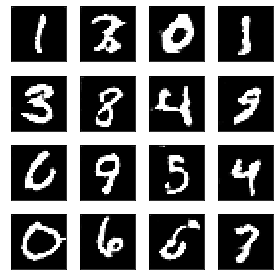

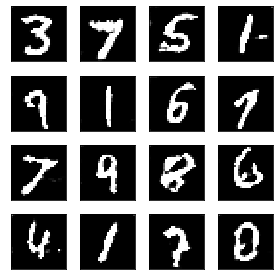

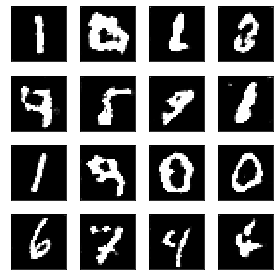

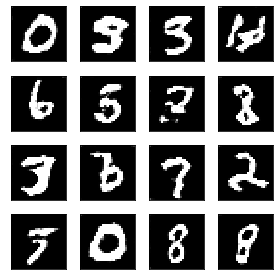

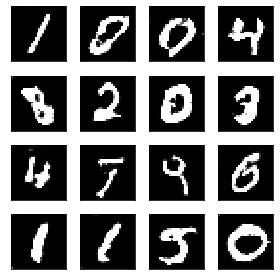

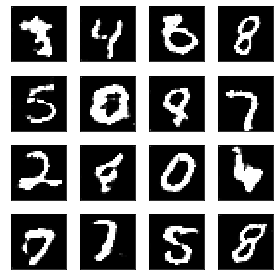

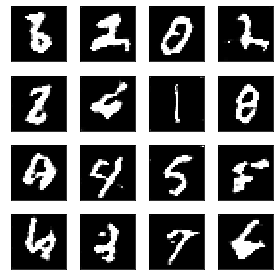

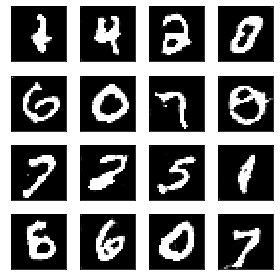

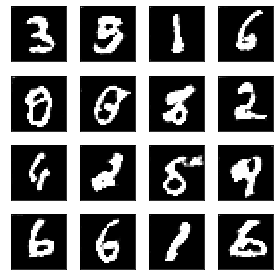

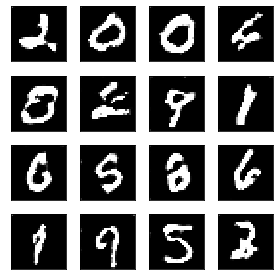

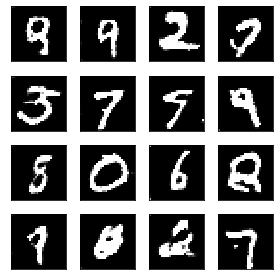

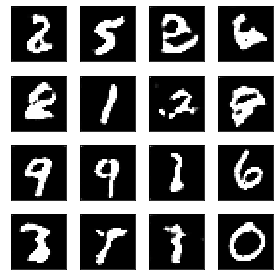

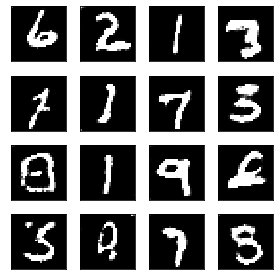

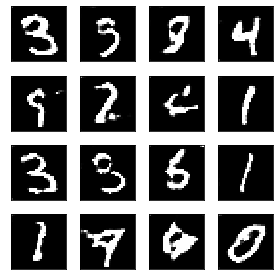

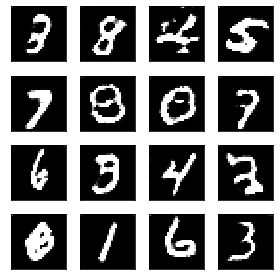

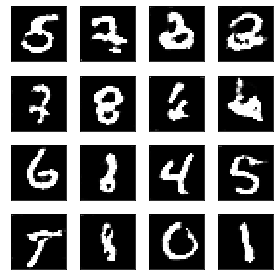

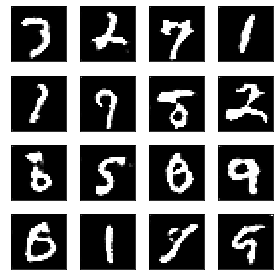

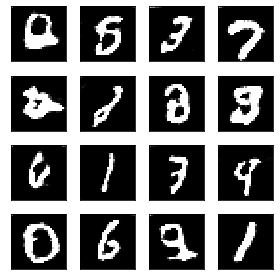

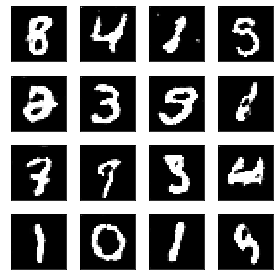

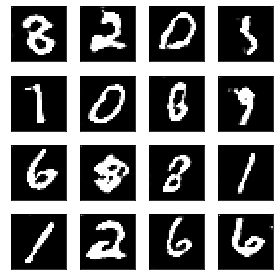

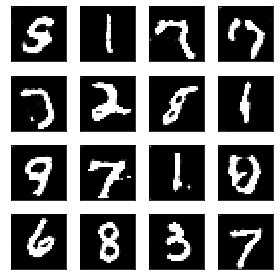

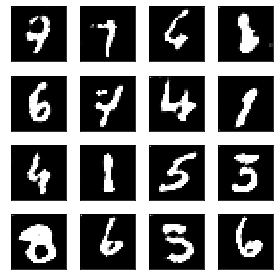

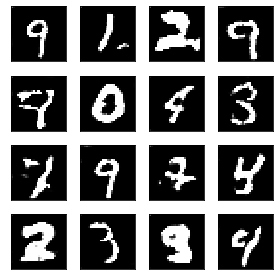

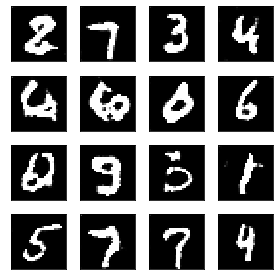

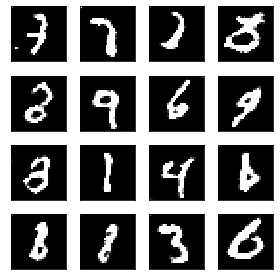

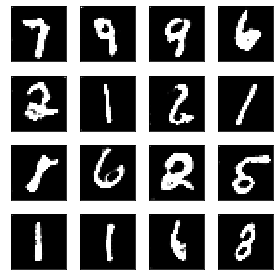

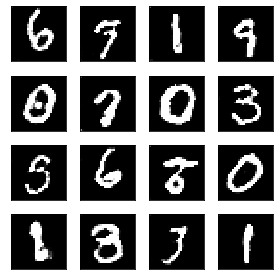

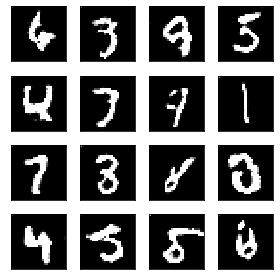

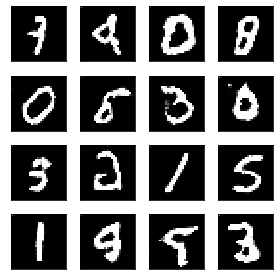

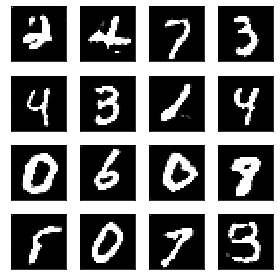

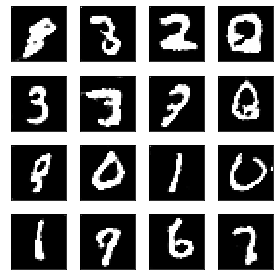

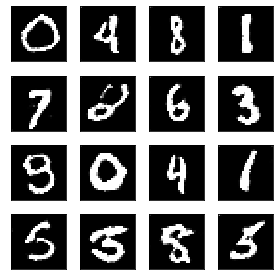

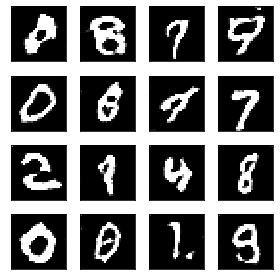

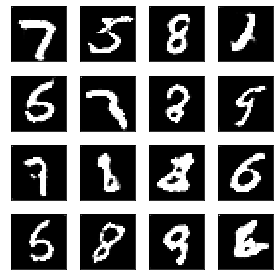

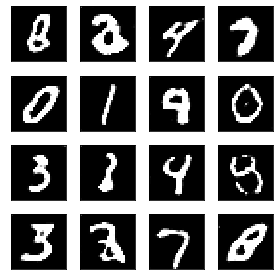

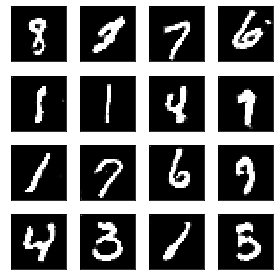

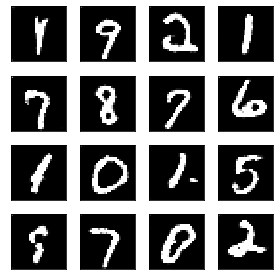

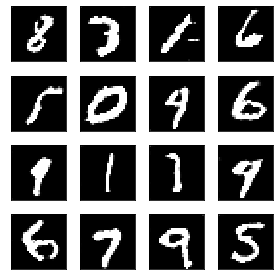

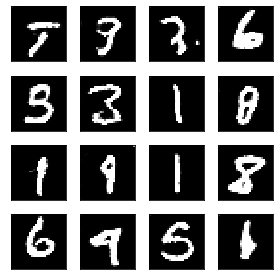

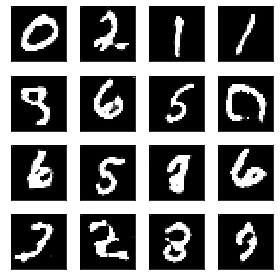

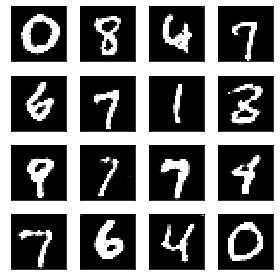

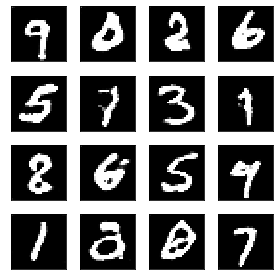

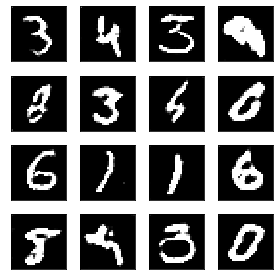

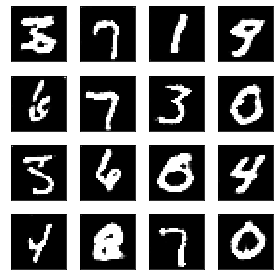

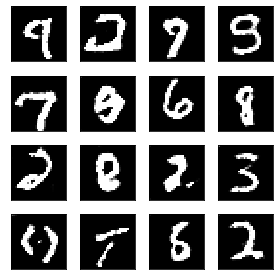

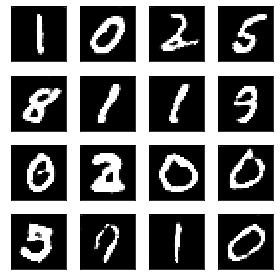

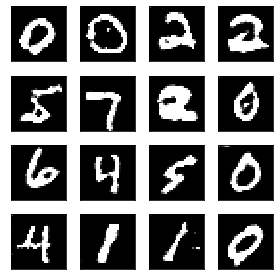

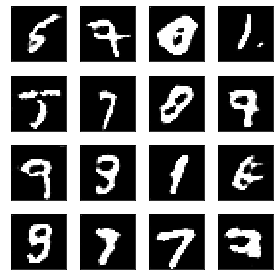

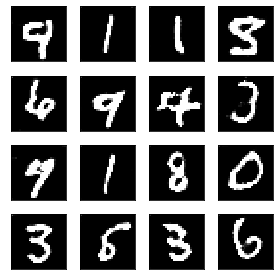

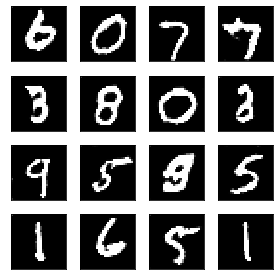

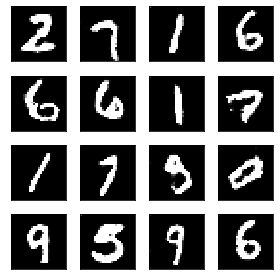

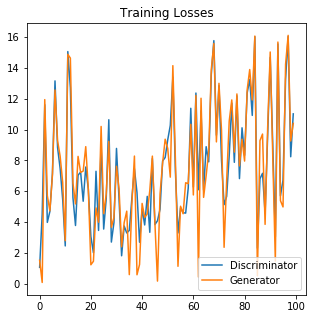

In [23]:
train(g_learning_rate=0.0001, g_beta_1=0.9, d_learning_rate=0.001, d_beta_1=0.9, leaky_alpha=0.2);